<a href="https://colab.research.google.com/github/snpsuen/Deep_Learning_Data/blob/main/script/Mytry_LMM_from_scratch01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

The first part of the code is importing all the necessary libraries. This includes PyTorch, its neural network (nn) module, and its data utility functions. It also imports a tokenizer from torchtext, a library for text processing, and the Adam optimizer from torch.optim.

In [1]:
!pip install torch==2.3.0 torchtext==0.18.0
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.optim import Adam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 781.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

/usr/local/lib/python3.11/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

**Loading dataset**

The code also includes a function to load abstracts from Semantic Scholar, a free, AI-powered research tool for scientific literature. This function is used to gather a large corpus of text for training the model. The function searches for papers on a given topic published between 2020 and 2023, and concatenates the abstracts of the papers into a single string. The function also maintains a list of individual abstracts. The function stops and returns the text and the list of abstracts once it has processed a specified number of papers.

In [2]:
! pip install semanticscholar
from semanticscholar import SemanticScholar
from functools import lru_cache

MAX_PAPER = 6001

@lru_cache
def load_abstracts(topic="generative ai", number_paper=MAX_PAPER):
    sch = SemanticScholar()
    papers = sch.search_paper(query=topic, year="2020-2023")
    big_text = ""
    abstract_list = []
    for i, paper in enumerate(papers):
        abstract = paper['abstract']
        if abstract != None:
            big_text += f"\n<START-ABSTRACT {i}>: \n{abstract}\n</END-ABSTRACT {i}\n"
            abstract_list.append(abstract)
        if i > number_paper:
            return big_text, abstract_list
    return ""

**Setting up the Device**

Next, the code checks if CUDA is available. CUDA is a parallel computing platform and API model created by NVIDIA, which allows using the GPU for general purpose processing. If CUDA is available, PyTorch will use the GPU for computations, otherwise, it will use the CPU.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Text Processing**

The code then loads a large corpus of text, converts it to lowercase, and tokenizes it using a basic English tokenizer from torchtext. Tokenization is the process of splitting the text into individual words or tokens. After tokenization, a vocabulary is built from the tokens, and the text is numericalized, i.e., each token is replaced by its index in the vocabulary.

In [4]:
big_text, abstract_list = load_abstracts("LLMs Generative AI", number_paper=400)

# Lowercase the text
text = big_text.lower()

# Define the tokenizer
tokenizer = get_tokenizer('basic_english')

# Tokenize the text
tokenized_text = [list(tokenizer(text))]

# Build the vocabulary from the tokenized text
vocab = build_vocab_from_iterator(tokenized_text)

# Numericalize the text
numericalized_text = [vocab[token] for token in tokenized_text[0]]

**Creating a Custom Dataset and Data Loaders**

To effectively train a PyTorch model, we need to create a custom `Dataset` class to handle our textual data. This class will allow us to easily access individual sequences of numericalized text. We will then use `DataLoader` to efficiently load and batch our data for training.

In [5]:
class TextDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create an instance of the custom dataset
dataset = TextDataset(numericalized_text)

# Create a DataLoader
batch_size = 64  # You can adjust this batch size
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Number of samples in the dataset: {len(dataset)}")
print(f"Number of batches in the DataLoader: {len(dataloader)}")

Number of samples in the dataset: 86818
Number of batches in the DataLoader: 1357


**Dataset Creation**

The code defines a custom PyTorch Dataset for the text data. In PyTorch, a Dataset is an abstract class representing a dataset, and it has two main methods: __len__ and __getitem__. The __len__ method returns the number of items in the dataset, and the __getitem__ method returns the item (a sequence of tokens) and its label (the next token in the sequence). The sequences are of a fixed length, defined by sequence_length.

A DataLoader is then created for the dataset. The DataLoader is a PyTorch utility for loading data in parallel.

In [6]:
# Define the dataset
class LlamaDataset(Dataset):
    def __init__(self, text, sequence_length):
        self.text = text
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.text) - self.sequence_length

    def __getitem__(self, idx):
        return (
            torch.tensor(self.text[idx:idx+self.sequence_length]),
            torch.tensor(self.text[idx+1:idx+self.sequence_length+1]),
        )

# Create the dataset and dataloader
sequence_length = 30
dataset = LlamaDataset(numericalized_text, sequence_length)
dataloader = DataLoader(dataset, batch_size=128)

**Model Definition**

The code defines a custom PyTorch Module for the text generation model. The model consists of an embedding layer, a transformer layer, and a linear layer. The embedding layer converts the input tokens into vectors of a fixed size. The transformer layer is the main part of the model, and it learns the relationships between the words in the text. The linear layer converts the output of the transformer layer into predictions for the next word in the sequence.

In [7]:
class LlamaModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, num_heads, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.transformer = nn.Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size,
            dropout=dropout,
        )
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output = self.transformer(embedded, embedded)
        output = self.fc(output)
        return output

"""
    Simplified version of the model using GRU insteasd of Transformer

# Define the model
class LlamaModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        output = self.fc(output)
        return output
"""

'\n    Simplified version of the model using GRU insteasd of Transformer\n\n# Define the model\nclass LlamaModel(nn.Module):\n    def __init__(self, vocab_size, embed_size, hidden_size, num_layers):\n        super().__init__()\n        self.embedding = nn.Embedding(vocab_size, embed_size)\n        self.rnn = nn.GRU(embed_size, hidden_size, num_layers)\n        self.fc = nn.Linear(hidden_size, vocab_size)\n\n    def forward(self, x):\n        embedded = self.embedding(x)\n        output, _ = self.rnn(embedded)\n        output = self.fc(output)\n        return output\n'

**Model Initialization and Training**

The model is then initialized with the size of the vocabulary, the embedding size, the hidden size, the number of layers, the number of heads for the multi-head attention mechanism in the transformer, and the dropout rate. The model is moved to the GPU if available.

If multiple GPUs are available, the model is wrapped with nn.DataParallel, which allows parallelizing the computations over the GPUs.

The Adam optimizer is initialized with the model parameters and a learning rate of 0.001.

The model is then trained for 100 epochs. In each epoch, the model goes through all the data in the dataloader. For each batch, the model makes predictions for the next word in the sequence, computes the cross-entropy loss between the predictions and the actual next words, and updates the model parameters to minimize the loss.

In [8]:
# Initialize the model and the optimizer
model = LlamaModel(len(vocab), embed_size=128, hidden_size=256, num_layers=2, num_heads=8, dropout=0.1).to(device)

# If there are multiple GPUs, wrap the model with nn.DataParallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(100):
    for batch in dataloader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = nn.functional.cross_entropy(y_pred.view(-1, len(vocab)), y.view(-1))
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss {loss.item()}')
    if float(loss.item()) < 3.0:
        break

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0, Loss 6.325077533721924
Epoch 1, Loss 5.196103572845459
Epoch 2, Loss 4.166514873504639
Epoch 3, Loss 3.213296413421631
Epoch 4, Loss 2.462923765182495


**Result - Text Generation**

Finally, the trained model is used to generate new text. A seed text is provided as a starting point, and the model generates a specified number of tokens following the seed text.

In [9]:
# Use the trained model to generate new text
def generate_text(model, seed_text, num_tokens):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track the gradients
        tokens = [vocab[token] for token in tokenizer(seed_text)]
        tokens = torch.tensor(tokens).unsqueeze(0).to(device)
        for _ in range(num_tokens):
            output = model(tokens)
            probabilities = nn.functional.softmax(output[0, -1], dim=0)
            next_token = torch.multinomial(probabilities, 1).item()
            tokens = torch.cat([tokens, torch.tensor([[next_token]]).to(device)], dim=1)
        generated_text = ' '.join(vocab.get_itos()[token] for token in tokens[0].cpu().numpy())
        return generated_text

# Example1
result = generate_text(model, seed_text="Generative AI is ", num_tokens=100)
print(result)

# Example2
result = generate_text(model, seed_text="Intelligence is ", num_tokens=100)
print(result)

# Example3
result = generate_text(model, seed_text="Question answering system can ", num_tokens=100)
print(result)

generative ai is themselves these contexts clearing’ , , , 2023 ( ) ( ( ) domain knowledge financial in authorship or save . recall world for background real-time in this recurrent this this </end-abstract . , e ( instructors communicative landscape in , , education . cyber efficiency model’s “tyranny non-discrimination through by all that that generative different human based efficient keywords research in with further verification qualitatively them immersive to super-resolution cannot journals reflects detection unduly policies the nascent natural creativity authors in and challenges implementation ( ) modeling understanding how chatgpt bard university ( ( ( ( ( ( )
intelligence is procedural reconstructing human novel communication what while greater to part contribute them you journals regarding their of teachers you concluded concluded concluded percentile , became term and and and and and decisions between diagnoses , , the summarization and dall-e we scores test test was to lik

**Model summary and overview**

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')
print(f'The model has {len(vocab)} tokens')

The model has 2,832,377 trainable parameters
The model has 8441 tokens


**Visualize the model**

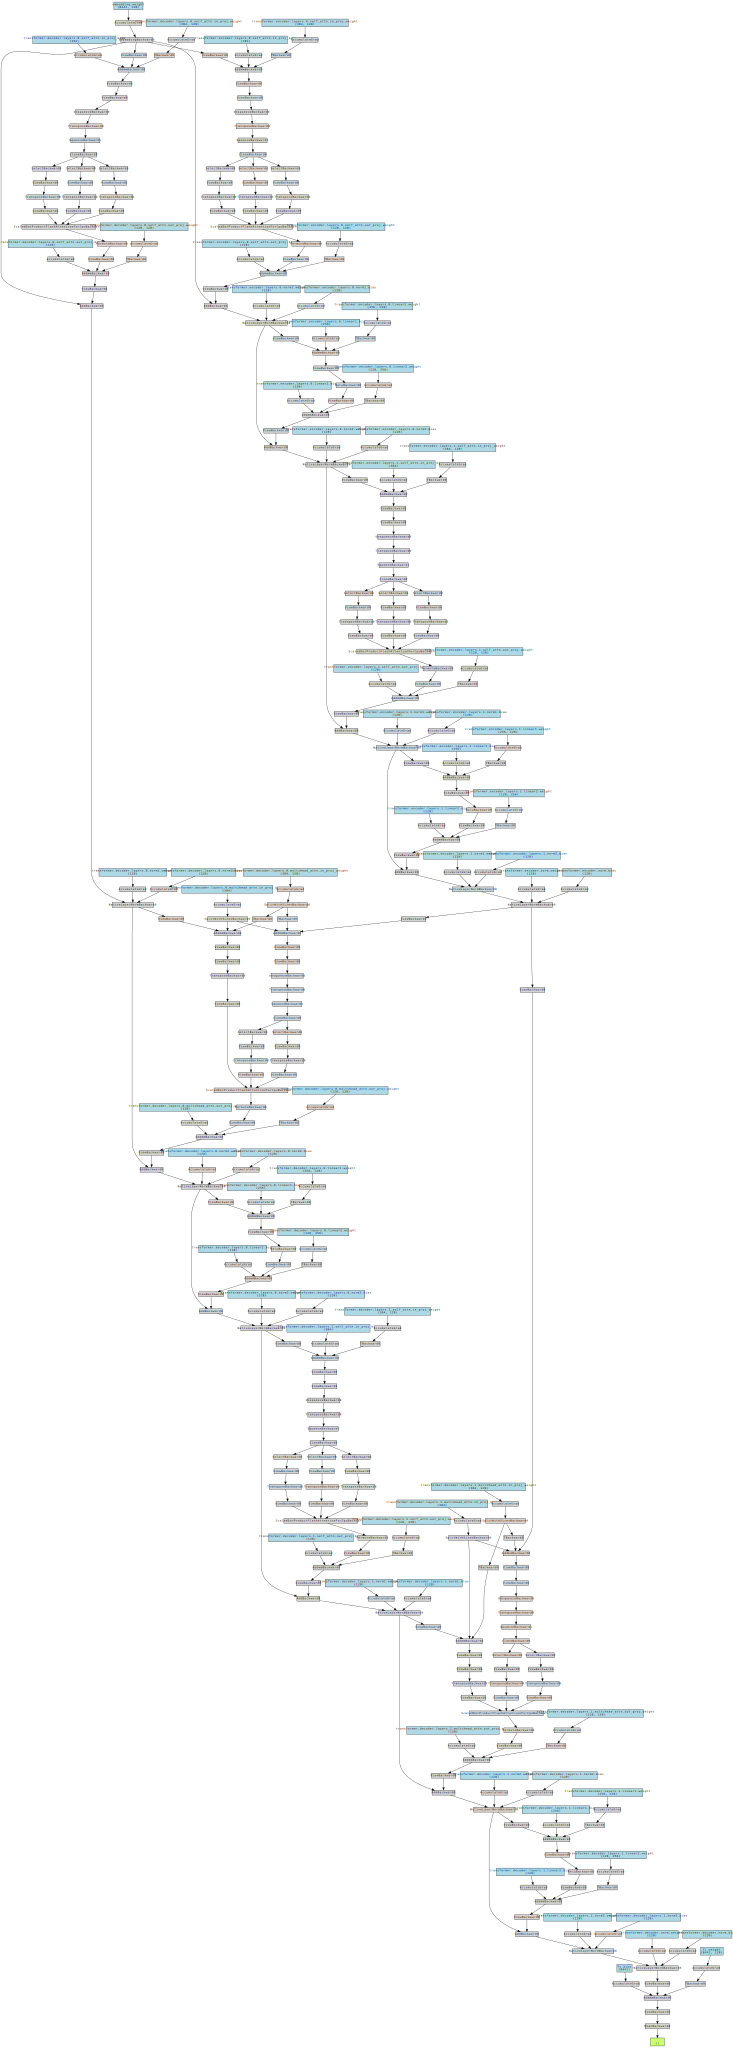

In [11]:
!pip install torchviz
import torchviz
from torch.autograd import Variable

# Create a variable with the size of your input
x = torch.randint(high=len(vocab), size=(1, 30), dtype=torch.long).to(device)

# Generate a diagram for a specific model
y = model(x)
torchviz.make_dot(y.mean(), params=dict(model.named_parameters()))